In [5]:
import numpy as np
import math
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from keras import models, layers, optimizers, metrics, losses, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sn
from keras.layers import ZeroPadding3D
from scipy import io as sio
import os
from matplotlib import pyplot as plt

In [6]:
!wget http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat

--2021-12-03 16:57:13--  http://www.ehu.eus/ccwintco/uploads/e/ee/PaviaU.mat
Resolving www.ehu.eus (www.ehu.eus)... 158.227.0.65, 2001:720:1410::65
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34806917 (33M)
Saving to: ‘PaviaU.mat’

PaviaU.mat          100%[===================>]  33.19M   571KB/s    in 61s     

2021-12-03 16:58:15 (556 KB/s) - ‘PaviaU.mat’ saved [34806917/34806917]

--2021-12-03 16:58:15--  http://www.ehu.eus/ccwintco/uploads/5/50/PaviaU_gt.mat
Connecting to www.ehu.eus (www.ehu.eus)|158.227.0.65|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11005 (11K)
Saving to: ‘PaviaU_gt.mat’

PaviaU_gt.mat       100%[===================>]  10.75K  --.-KB/s    in 0s      

2021-12-03 16:58:15 (101 MB/s) - ‘PaviaU_gt.mat’ saved [11005/11005]

FINISHED --2021-12-03 16:58:15--
Total wall clock time: 1m 2s
Downloaded: 2 files, 33M in 1m 1s (556 KB/s)


In [7]:
!ls

PaviaU_gt.mat  PaviaU.mat  sample_data


## Read the Data

In [8]:
from scipy.io import loadmat

def read_HSI():
  X = loadmat('PaviaU.mat')['paviaU']
  y = loadmat('PaviaU_gt.mat')['paviaU_gt']
  print(f"X shape: {X.shape}\ny shape: {y.shape}")
  return X, y

X, y = read_HSI()

X shape: (610, 340, 103)
y shape: (610, 340)


## Visualize bands

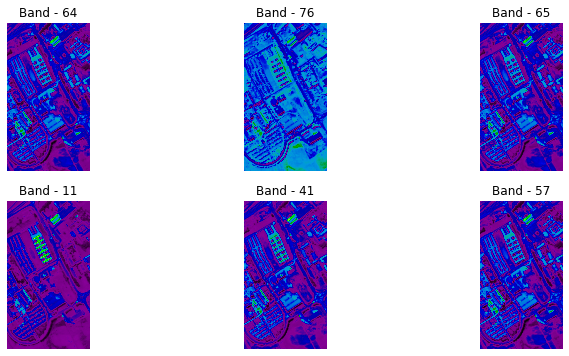

In [9]:
fig = plt.figure(figsize = (12, 6))

for i in range(1, 1+6):
    fig.add_subplot(2,3, i)
    q = np.random.randint(X.shape[2])
    plt.imshow(X[:,:,q], cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {q}')
plt.savefig('UP_Bands.png')

### Visualize the Ground Truth

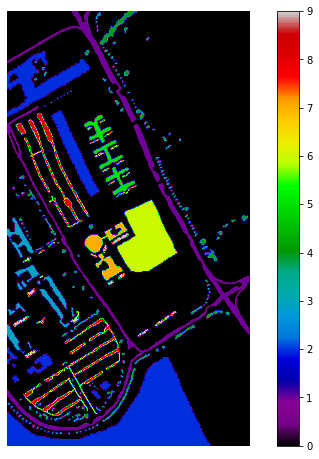

In [10]:
plt.figure(figsize=(10, 8))
plt.imshow(y, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('UP_GT.png')
plt.show()

## Convert the dataset into csv 

In [11]:
import pandas as pd
import numpy as np

def extract_pixels(X, y):
  q = X.reshape(-1, X.shape[2])
  df = pd.DataFrame(data = q)
  df = pd.concat([df, pd.DataFrame(data = y.ravel())], axis=1)
  df.columns= [f'band{i}' for i in range(1, 1+X.shape[2])]+['class']
  df.to_csv('Dataset.csv')
  return df
  
df = extract_pixels(X, y)


In [12]:
df.head()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,band13,band14,band15,band16,band17,band18,band19,band20,band21,band22,band23,band24,band25,band26,band27,band28,band29,band30,band31,band32,band33,band34,band35,band36,band37,band38,band39,band40,...,band65,band66,band67,band68,band69,band70,band71,band72,band73,band74,band75,band76,band77,band78,band79,band80,band81,band82,band83,band84,band85,band86,band87,band88,band89,band90,band91,band92,band93,band94,band95,band96,band97,band98,band99,band100,band101,band102,band103,class
0,647,499,464,371,291,319,365,322,296,305,277,219,219,222,201,162,157,183,204,194,198,216,249,284,294,322,338,342,336,342,362,365,348,341,324,316,293,274,251,244,...,192,227,287,376,493,633,763,913,1149,1442,1759,2102,2425,2689,2895,3058,3196,3252,3195,3297,3542,3550,3537,3545,3514,3477,3468,3433,3408,3420,3416,3335,3256,3226,3205,3210,3221,3238,3250,0
1,604,546,527,455,378,377,336,314,324,329,328,326,275,215,197,217,239,258,246,233,241,261,279,300,329,344,341,362,362,367,368,359,345,344,327,302,281,271,270,261,...,152,190,242,301,391,505,633,774,960,1191,1454,1737,2001,2209,2363,2484,2594,2613,2541,2588,2821,2839,2738,2690,2678,2673,2712,2725,2657,2605,2583,2538,2509,2511,2501,2468,2442,2464,2528,0
2,621,746,556,360,285,300,274,276,332,319,278,255,232,207,210,209,168,139,137,154,168,202,225,231,244,257,263,262,266,276,285,291,285,272,271,241,208,194,179,157,...,116,153,188,243,322,413,492,591,737,933,1125,1327,1519,1666,1790,1934,2029,2034,2010,2069,2191,2233,2245,2249,2255,2250,2249,2239,2239,2282,2288,2242,2193,2202,2225,2266,2308,2345,2361,0
3,637,592,482,556,508,284,178,198,193,224,217,215,187,161,152,136,124,122,127,126,125,123,147,188,208,203,202,206,219,235,238,227,217,215,216,201,190,167,149,162,...,129,174,245,338,455,585,720,850,1013,1225,1460,1702,1938,2157,2317,2433,2525,2552,2493,2554,2733,2781,2748,2748,2737,2710,2681,2642,2645,2684,2675,2609,2541,2551,2571,2569,2573,2620,2644,0
4,625,560,480,360,377,341,264,208,231,266,207,154,123,95,106,102,101,123,154,170,191,210,216,256,289,325,348,357,361,362,363,370,386,369,344,331,312,308,288,263,...,173,220,292,382,488,592,692,834,1032,1236,1461,1698,1876,2007,2118,2213,2288,2267,2192,2274,2448,2454,2387,2388,2441,2435,2454,2457,2430,2423,2392,2344,2289,2328,2415,2424,2386,2431,2456,0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207400 entries, 0 to 207399
Columns: 104 entries, band1 to class
dtypes: uint16(103), uint8(1)
memory usage: 40.9 MB


In [14]:
df.iloc[:, :-1].describe()

,band1,band2,band3,band4,band5,band6,band7,band8,band9,band10,band11,band12,band13,band14,band15,band16,band17,band18,band19,band20,band21,band22,band23,band24,band25,band26,band27,band28,band29,band30,band31,band32,band33,band34,band35,band36,band37,band38,band39,band40,...,band64,band65,band66,band67,band68,band69,band70,band71,band72,band73,band74,band75,band76,band77,band78,band79,band80,band81,band82,band83,band84,band85,band86,band87,band88,band89,band90,band91,band92,band93,band94,band95,band96,band97,band98,band99,band100,band101,band102,band103
count,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.00000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,...,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000,207400.000000
mean,925.324995,850.237584,800.363558,809.889783,830.085950,834.162700,833.530641,825.932729,823.827637,830.388689,838.761900,833.532261,833.957903,840.022734,846.49027,849.024166,858.274605,869.041553,879.729687,893.426895,909.047888,929.773245,950.449826,971.719296,999.330747,1030.487247,1047.342570,1056.144036,1064.008298,1078.164397,1094.337912,1102.542194,1106.111823,1112.674807,1116.410511,1117.368182,1116.463134,1115.816958,1115.709667,1116.513134,...,1151.786355,1167.364634,1196.965762,1242.671355,1300.318158,1374.747102,1451.015511,1524.074653,1596.037252,1671.897768,1753.491707,1835.790125,1922.294619,1996.554687,2063.378761,2114.096861,2155.272912,2194.415844,2216.565135,2212.345323,2193.142758,2210.446374,2232.427758,2245.315858,2245.806716,2246.235497,2253.048669,2267.367917,2265.880313,2257.890217,2262.503269,2266.693293,2257.763443,2249.329595,2246.216779,2238.254364,2231.822647,2224.744884,2236.901707,2253.451692
std,444.427499,468.464292,493.590158,527.235307,555.419089,574.543548,592.474167,605.782075,619.492506,636.532214,654.150867,663.504620,675.055950,685.877447,694.17722,700.069128,706.904269,710.988908,712.225631,712.766144,711.116605,707.754548,702.056494,696.329369,694.323524,695.658318,691.457118,685.112863,680.143249,679.484331,680.548766,678.991678,678.109958,681.818279,686.403595,691.668118,696.466303,700.002590,701.182840,700.248079,...,736.586216,724.016756,708.647458,695.452171,674.953291,653.314752,632.543791,615.486140,603.333136,597.054264,605.347893,629.388781,667.016967,708.788296,750.020598,785.134096,814.465202,840.078731,856.606082,852.494726,820.735878,830.340437,856.128856,869.604098,871.258687,870.414926,870.642830,872.611679,868.905723,863.646853,863.285910,863.351557,857.286520,845.571285,833.001117,826.922155,827.403828,827.257369,834.092348,844.165146
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,10.000000,16.000000,16.000000,26.000000,37.000000,41.000000,59.000000,71.000000,72.0000


## Principal Component Analysis(PCA)

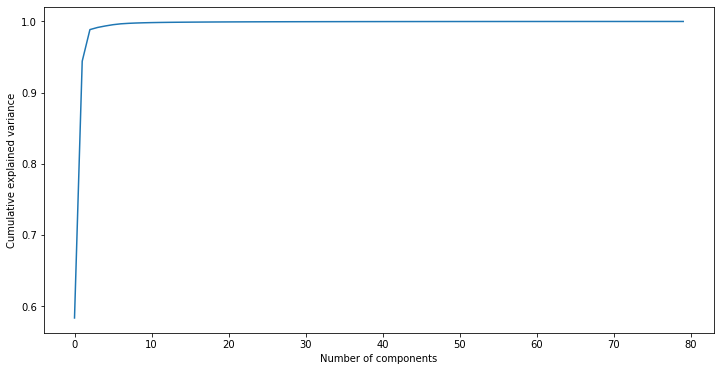

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 80)# 95 115 max 103

principalComponents = pca.fit_transform(df.iloc[:, :-1].values)

ev=pca.explained_variance_ratio_

plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(ev))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')


plt.show()


Select 40 as the no.of components for PCA

In [16]:
pca = PCA(n_components = 15) #10 5 15 
dt = pca.fit_transform(df.iloc[:, :-1].values)
q = pd.concat([pd.DataFrame(data = dt), pd.DataFrame(data = y.ravel())], axis = 1)
q.columns = [f'PC-{i}' for i in range(1,16)]+['class']

In [17]:
q.head()

,PC-1,PC-2,PC-3,PC-4,PC-5,PC-6,PC-7,PC-8,PC-9,PC-10,PC-11,PC-12,PC-13,PC-14,PC-15,class
0,-5150.190044,6795.052770,1532.351461,410.030133,-259.856156,-832.898965,293.239787,278.385259,-285.609789,251.210748,-283.850526,11.788157,92.287106,-9.579601,-58.938541,0
1,-6082.245760,3158.592195,1463.194744,154.617093,-438.871878,-496.202150,362.925836,187.355363,-287.796671,180.611939,-245.039595,-57.677321,75.405955,-18.947166,1.534807,0
2,-7214.505405,1158.875812,1400.817899,410.044063,38.052916,-560.804194,-140.004198,8.847691,-211.057600,14.141426,-260.361207,60.933025,25.493954,39.136887,86.540176,0
3,-6566.279360,3398.894763,1126.024772,496.775042,-302.415251,-409.493900,218.391585,-2.957265,-223.379993,188.820405,-125.721787,-204.733263,107.567619,-57.301121,60.146393,0
4,-6496.967970,2154.797771,1035.954575,27.247704,-194.891402,-189.044602,-71.142478,-97.987742,-126.456375,215.182574,-199.702577,2.999423,11.947503,-2.833207,18.574775,0


### Display the bands after PCA

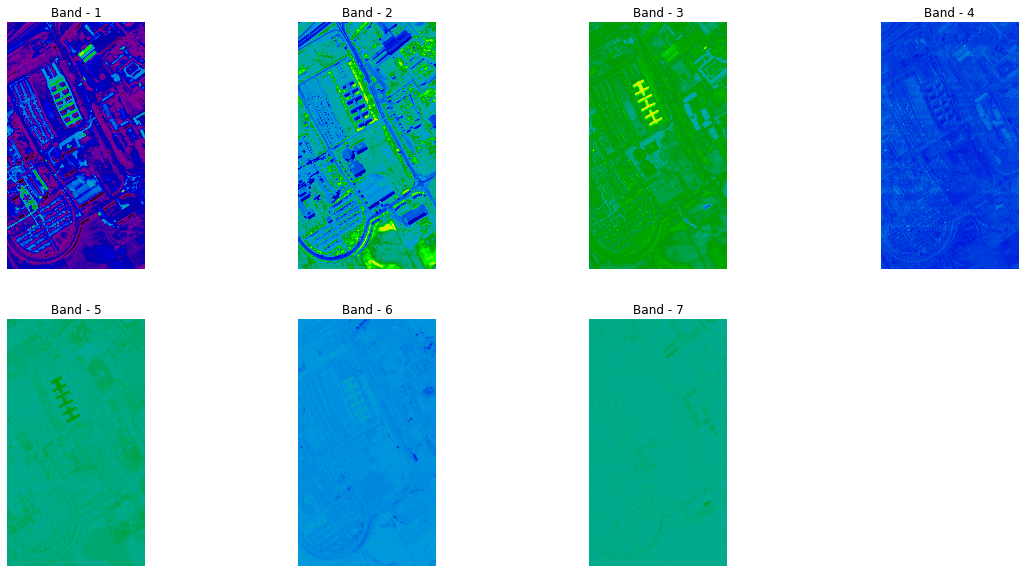

In [18]:
fig = plt.figure(figsize = (20, 10))

for i in range(1, 1+7):
    fig.add_subplot(2,4, i)
    plt.imshow(q.loc[:, f'PC-{i}'].values.reshape(610,340), cmap='nipy_spectral')
    plt.axis('off')
    plt.title(f'Band - {i}')

plt.savefig('UP_PCA_Bands.png')

## Support Vector Machine(SVM)


In [19]:
x = q[q['class'] != 0]

X = x.iloc[:, :-1].values

y = x.loc[:, 'class'].values 

names = ['Asphalt','Meadows','Gravel','Trees','Painted metal sheets','Bare Soil','Bitumen	','Self-Blocking Bricks','Shadows']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=11, stratify=y) #test 5,10,15,20,25,30
svm =  SVC(C = 100, kernel = 'rbf', cache_size = 10*1024) #kernel change

svm.fit(X_train, y_train)
ypred = svm.predict(X_test)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 9 missing from current font.
  font.set_text(s, 0, flags=flags)


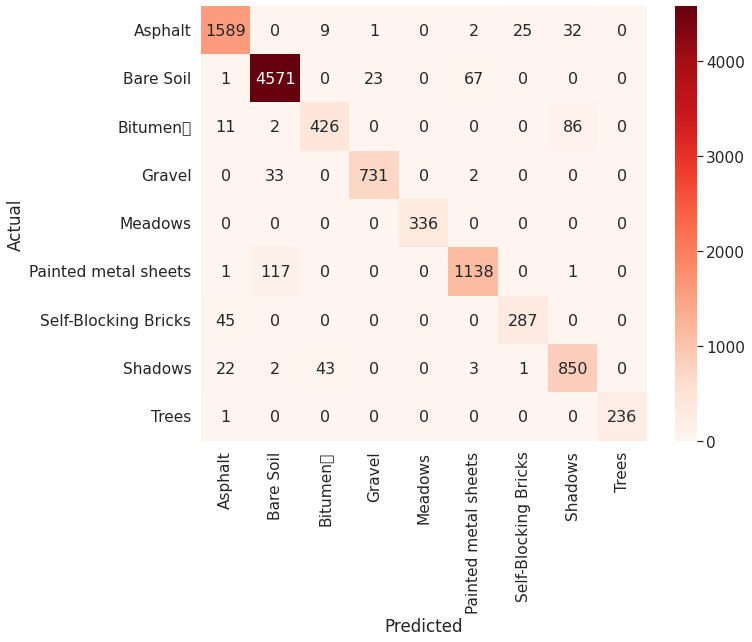

In [20]:
data = confusion_matrix(y_test, ypred)
df_cm = pd.DataFrame(data, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap.png', dpi=300)

In [21]:
print(classification_report(y_test, ypred, target_names = names))

                      precision    recall  f1-score   support

             Asphalt       0.95      0.96      0.95      1658
             Meadows       0.97      0.98      0.97      4662
              Gravel       0.89      0.81      0.85       525
               Trees       0.97      0.95      0.96       766
Painted metal sheets       1.00      1.00      1.00       336
           Bare Soil       0.94      0.91      0.92      1257
            Bitumen	       0.92      0.86      0.89       332
Self-Blocking Bricks       0.88      0.92      0.90       921
             Shadows       1.00      1.00      1.00       237

            accuracy                           0.95     10694
           macro avg       0.95      0.93      0.94     10694
        weighted avg       0.95      0.95      0.95     10694



## Classification Map

In [22]:
l=[]
for i in range(q.shape[0]):
  if q.iloc[i, -1] == 0:
    l.append(0)
  else:
    l.append(svm.predict(q.iloc[i, :-1].values.reshape(1, -1)))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


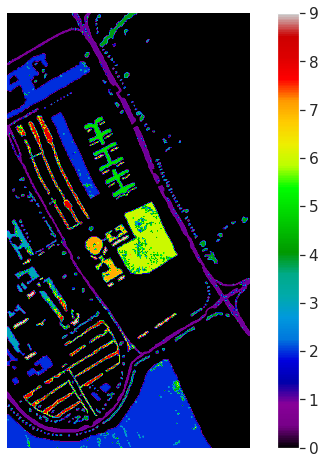

In [23]:
clmap = np.array(l).reshape(610,340).astype('float')
plt.figure(figsize=(10, 8))
plt.imshow(clmap, cmap='nipy_spectral')
plt.colorbar()
plt.axis('off')
plt.savefig('SA_cmap.png')
plt.show()

In [24]:
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [25]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.9333270993080232


In [26]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 11.083972320927623
Mean Squared Error: 1.3977931550402094
Root Mean Squared Error: 1.1822830266227327


In [27]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))
print(accuracy_score(y_test, y_pred))

[[1587    3    8    0    0   11   10   39    0]
 [   0 4601    0   30    0   31    0    0    0]
 [  25    3  386    0    0    0    0  111    0]
 [   0   73    0  690    0    3    0    0    0]
 [   0    0    0    0  336    0    0    0    0]
 [   2  223    0    1    0 1030    0    1    0]
 [  65    0    0    0    0    0  267    0    0]
 [  28   12   26    0    0    5    1  849    0]
 [   2    0    0    0    0    0    0    0  235]]
              precision    recall  f1-score   support

           1       0.93      0.96      0.94      1658
           2       0.94      0.99      0.96      4662
           3       0.92      0.74      0.82       525
           4       0.96      0.90      0.93       766
           5       1.00      1.00      1.00       336
           6       0.95      0.82      0.88      1257
           7       0.96      0.80      0.88       332
           8       0.85      0.92      0.88       921
           9       1.00      0.99      1.00       237

    accuracy             

## Factor Analysis

In [28]:
!pip install factor_analyzer

array([6.68013320e+01, 2.93105600e+01, 5.29537126e+00, 9.92559269e-01,
       5.14319425e-01, 2.62031963e-01, 2.18439779e-01, 1.76603619e-01,
       1.09350135e-01, 6.43136412e-02, 4.52070762e-02, 3.00104735e-02,
       2.13140971e-02, 1.95789679e-02, 1.52176340e-02, 1.32249765e-02,
       1.00330018e-02, 7.91832267e-03, 7.61896942e-03, 6.72286728e-03,
       5.97738678e-03, 5.68041468e-03, 4.74787542e-03, 4.41872948e-03,
       4.00485577e-03, 3.44622219e-03, 3.32981239e-03, 2.66638197e-03,
       2.50135752e-03, 2.39787625e-03, 2.32374640e-03, 2.15019265e-03,
       2.05080133e-03, 1.94514971e-03, 1.76247452e-03, 1.67901003e-03,
       1.65567270e-03, 1.58685794e-03, 1.50681420e-03, 1.46395566e-03,
       1.31124782e-03, 1.23232773e-03, 1.11621518e-03, 1.10579704e-03,
       1.02084247e-03, 1.00353954e-03, 9.43492267e-04, 8.61294447e-04,
       8.37926265e-04, 8.17617279e-04, 7.35273433e-04, 7.00583291e-04,
       6.46389149e-04, 6.07399538e-04, 5.69717431e-04, 5.48733274e-04,
      

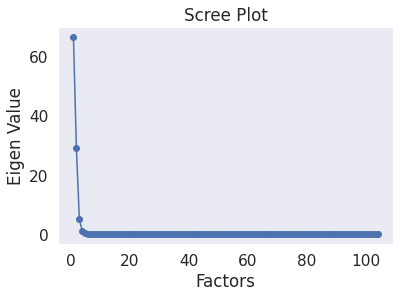

In [29]:
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(rotation = None,impute = "drop",n_factors=df.shape[1])
fa.fit(df)
ev,_ = fa.get_eigenvalues()
plt.scatter(range(1,df.shape[1]+1),ev)
plt.plot(range(1,df.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigen Value')
plt.grid()
ev